In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import interp1d
import pickle
import datetime

%matplotlib notebook
%matplotlib notebook

In [14]:
# Common frequency vector to interpolate onto
f_vec = pow(10, np.linspace(1,5, 500))

<IPython.core.display.Javascript object>


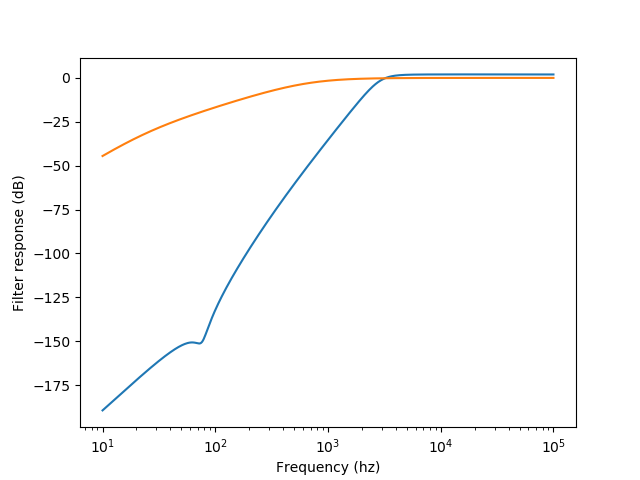

Text(0.5, 0, 'Frequency (hz)')

In [15]:
# HPF stage
d = np.loadtxt('v_filter.csv',delimiter=',', skiprows=1)
f = d[:,0]
filt_on= d[:,3]
filt_off=d[:,2]

fig, ax = plt.subplots(1,1)
# ax.plot(f, filt_on)
# ax.plot(f, filt_off)
# ax.set_yscale('log')
ax.set_xscale('log')

intsy = interp1d(f, 20*np.log10(filt_on))
filt_on_dB = intsy(f_vec)

intsy = interp1d(f, 20*np.log10(filt_off))
filt_off_dB = intsy(f_vec)

ax.plot(f_vec, filt_on_dB)
ax.plot(f_vec, filt_off_dB)
ax.set_ylabel('Filter response (dB)')
ax.set_xlabel('Frequency (hz)')


<IPython.core.display.Javascript object>


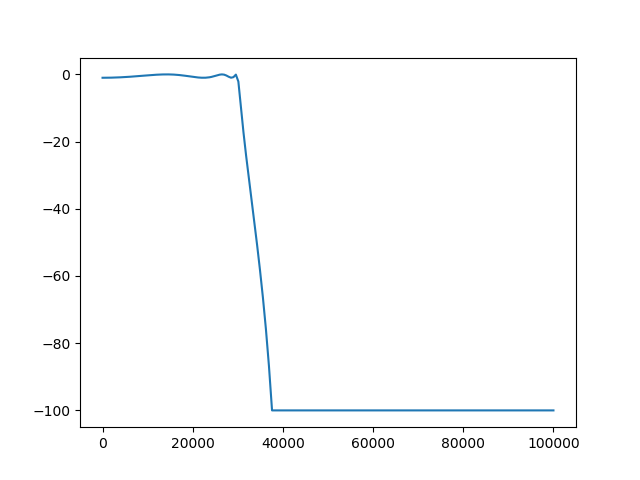

In [16]:
# LNA / AAF stage:
res_low_gain = 51.1
G_low = 25.486*2/res_low_gain


# G_hi = 25.486*2/(5.62*51)
res_hi_gain = 5.62*51.1/(5.62+51.1)
G_hi = 25.486*2/res_hi_gain

# Man, there is no fucking way that filter works this well. Lord. Jesus.
AAF_response = scipy.io.loadmat('AAF_simulated_response.mat')
AAF_freqs = np.ravel(AAF_response['x'][:])
AAF_mag_dB = np.ravel(AAF_response['y'][:])


# ax.plot(AAF_freqs, AAF_mag_dB)
# ax.set_ylim([-60,10])
intsy = interp1d(AAF_freqs*1000, AAF_mag_dB, bounds_error=False, fill_value='extrapolate')
AAF_response_dB = intsy(f_vec)
AAF_response_dB = np.clip(AAF_response_dB, -100, 100)  # it LIES, 40000 db rejection good fuckin' luck
fig, ax = plt.subplots(1,1)
ax.plot(f_vec, AAF_response_dB)


LNA_gain_hi  = 20*np.log10(G_hi)
LNA_gain_low = 20*np.log10(G_low)

<IPython.core.display.Javascript object>


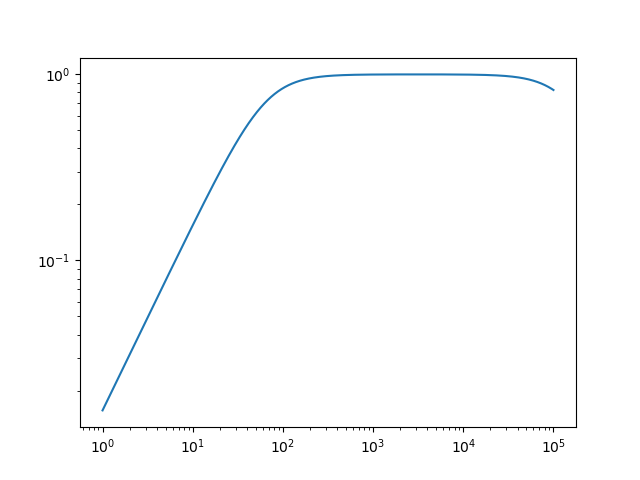

In [17]:
# ADC driver stage:
d = np.loadtxt('ADC_driver_sim.csv',delimiter=',', skiprows=1)
adc_driver_freqs = d[:,0]
adc_driver_response = d[:,2]

intsy = interp1d(adc_driver_freqs, 20*np.log10(adc_driver_response))
adc_driver_dB = intsy(f_vec)

fig, ax = plt.subplots(1,1)
ax.plot(adc_driver_freqs, adc_driver_response)
ax.set_yscale('log')
ax.set_xscale('log')

<IPython.core.display.Javascript object>


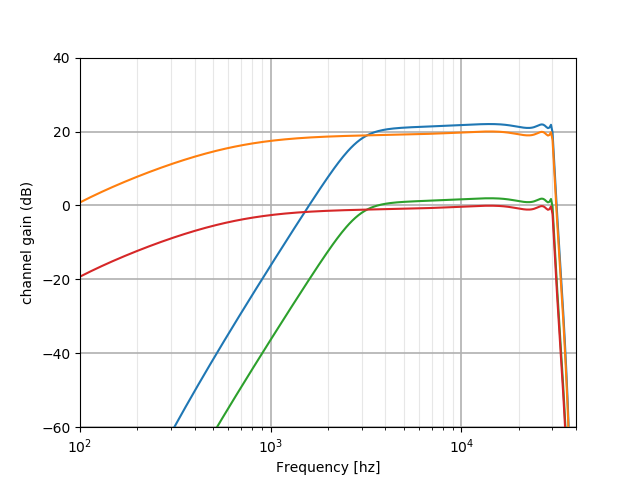

Text(0.5, 0, 'Frequency [hz]')

In [18]:
# Combined analog channel:
filt_on = True
high_gain = True

def get_response(filt_on, high_gain):
    channel_response = np.zeros_like(f_vec)
    # High-pass filter
    if filt_on:
        channel_response += filt_on_dB
    else:
        channel_response += filt_off_dB

    # LNA gain
    if high_gain:
        channel_response += LNA_gain_hi
    else:
        channel_response += LNA_gain_low

    #AAF:
    channel_response += AAF_response_dB

    # Driver:
    channel_response += adc_driver_dB
    return channel_response

fig, ax = plt.subplots(1,1)
ax.plot(f_vec, get_response(True, True))
ax.plot(f_vec, get_response(False, True))
ax.plot(f_vec, get_response(True, False))
ax.plot(f_vec, get_response(False, False))

ax.set_xscale('log')
ax.set_ylim([-60,40])
ax.set_xlim([100, 40000])
ax.grid(which='major', linewidth=1.2)
ax.grid(which='minor', alpha=0.3)
ax.set_ylabel('channel gain (dB)')
ax.set_xlabel('Frequency [hz]')
    

<IPython.core.display.Javascript object>


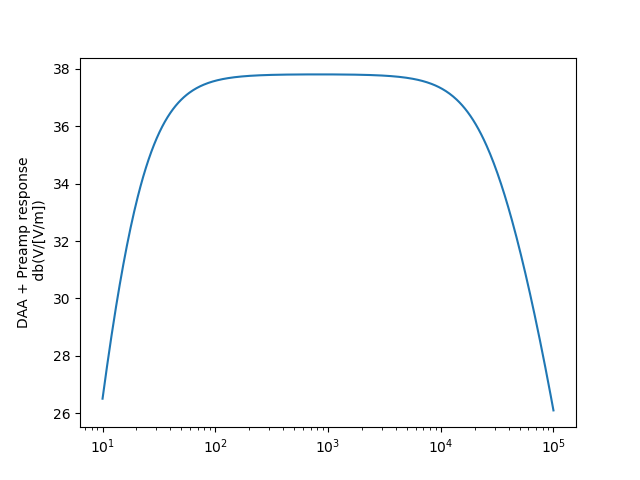

Text(0, 0.5, 'DAA + Preamp response\n db(V/[V/m])')

In [19]:
# Antenna coupling factors:

# E-field preamp
d = np.loadtxt('preamp_main_channel_gain.csv',delimiter=',', skiprows=1)
E_pre_freqs = d[:,0]
E_pre_gain  = d[:,1]

intsy = interp1d(E_pre_freqs, 20*np.log10(E_pre_gain))
E_preamp_dB = intsy(f_vec)



# This is insanely optimistic -- mapping the voltage at the antenna to the E field, in V/m.
# In the absense of a plasma, sure, it's pretty reasonable, but the plasma is going to 
# wreck everything. Also we're not terribly analytical about matching impedances.
# But at any rate, an effective antenna length of 1 meter should give us 1 volt in a 1v/m field.
# 
# If we have a better physics model, here's where it should go.
E_antenna_factor = 0  # dB([Volts / (volts/meter)])

E_ant_response = E_preamp_dB + E_antenna_factor  # dB(V / (V/m))

fig, ax = plt.subplots(1,1)
ax.plot(f_vec, E_ant_response)
ax.set_xscale('log')
ax.set_ylabel('DAA + Preamp response\n db(V/[V/m])')


<IPython.core.display.Javascript object>


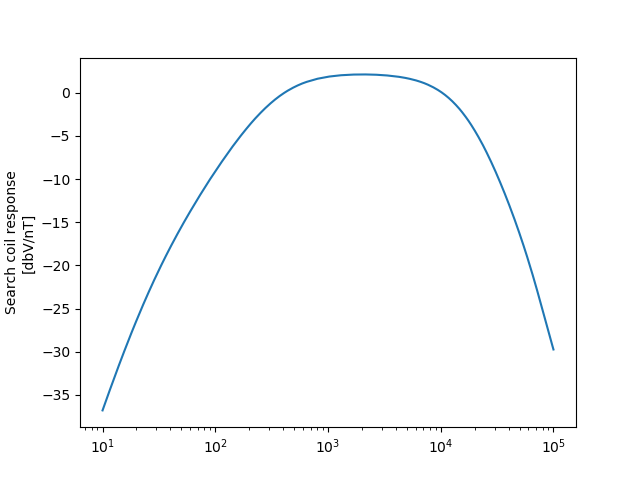

Text(0, 0.5, 'Search coil response\n[dbV/nT]')

In [20]:
# Magnetic search coil antenna coupling:

d = np.loadtxt('VPM MSC Gain Curve.csv',delimiter=',',skiprows=1)
MSC_freqs = d[:,0]
MSC_response = d[:,1]

intsy = interp1d(MSC_freqs, MSC_response)
B_ant_response = intsy(f_vec)



fig, ax = plt.subplots(1,1)
ax.plot(f_vec, B_ant_response)
ax.set_xscale('log')
ax.set_ylabel('Search coil response\n[dbV/nT]')

<IPython.core.display.Javascript object>


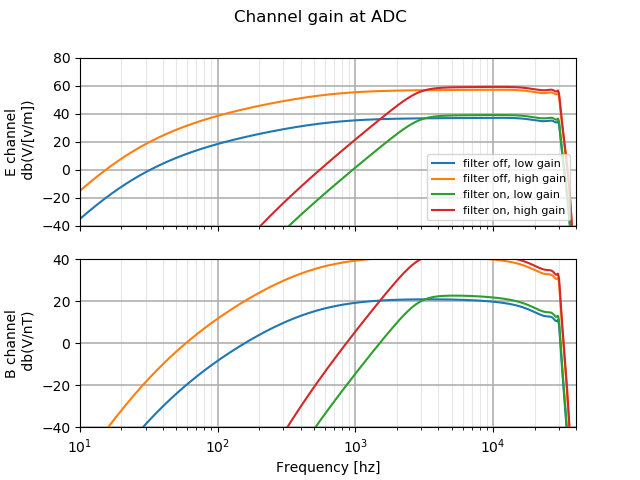

E coefficient: 36.98697658391696, B coefficient: 20.906579305428092
E coefficient: 57.06697471603594, B coefficient: 40.98657743754707
E coefficient: 38.99947136131364, B coefficient: 22.659433488853637
E coefficient: 59.079469493432626, B coefficient: 42.73943162097262


Text(0.5, 0, 'Frequency [hz]')

In [21]:
E_high_gain = True
E_filter = False
B_high_gain = True
B_filter = False

E_full_response = E_ant_response + get_response(E_filter,E_high_gain)
B_full_response = B_ant_response + get_response(B_filter,B_high_gain)

fig, ax = plt.subplots(2,1, sharex=True)
for filt, gain in [(False, False),(False, True), (True, False), (True,True)]:
    if filt:
        filt_str = "on"
    else:
        filt_str = "off"
    if gain:
        gain_str = "high"
    else:
        gain_str = "low"
    
    # Adding in 10 v/v gain to the B channel -- ADC driver is unity gain on E channel, +10 on B channel.
    # (no clue if this is what's in production)
    E_full_response = E_ant_response + get_response(filt, gain)
    B_full_response = B_ant_response + get_response(filt, gain) + 20*np.log10(10)
    
    
    E_coef = max(E_full_response)
    B_coef = max(B_full_response)
    print(f'E coefficient: {E_coef}, B coefficient: {B_coef}')
    ax[0].plot(f_vec, E_full_response, label=f'filter {filt_str}, {gain_str} gain')
    ax[1].plot(f_vec, B_full_response)
ax[1].set_xscale('log')
ax[0].set_ylim([-40,80])
ax[1].set_ylim([-40,40])
ax[1].set_xlim([10,40000])
fig.suptitle('Channel gain at ADC')
ax[0].set_ylabel('E channel\n db(V/[v/m])')
ax[1].set_ylabel('B channel\n db(V/nT)')
ax[0].grid(which='major', linewidth=1.2)
ax[0].grid(which='minor', alpha=0.3)
ax[1].grid(which='major', linewidth=1.2)
ax[1].grid(which='minor', alpha=0.3)
ax[0].legend(fontsize=8)
ax[1].set_xlabel('Frequency [hz]')

In [22]:
outs = dict()
for filt, gain in [(False, False),(False, True), (True, False), (True,True)]:
    E_full_response = E_ant_response + get_response(filt, gain)
    B_full_response = B_ant_response + get_response(filt, gain) + 20*np.log10(10)
    outs[('E',filt,gain)] = E_full_response
    outs[('B',filt,gain)] = B_full_response

    
outs['calibration_date'] = datetime.datetime.now
outs['description'] = "Austin's simulated calibration curve"
outs['E units'] = 'V / [V/m] at ADC'
outs['B units'] = 'V / nT at ADC'
# Save it
with open('../calibration_data.pkl','wb') as f:
    pickle.dump(outs,f)

<IPython.core.display.Javascript object>


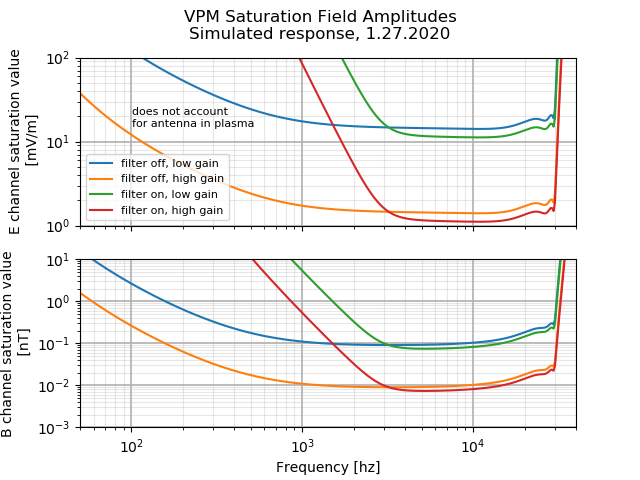

In [23]:
# Let's do the min/max range plots:

# Differential... 16 bit +- 1 volt
adc_max_val = 32727. 
adc_max_voltage = 1.0 

E_high_gain = True
E_filter = False
B_high_gain = True
B_filter = False

E_full_response = E_ant_response + get_response(E_filter,E_high_gain)
B_full_response = B_ant_response + get_response(B_filter,B_high_gain)

fig, ax = plt.subplots(2,1, sharex=True)
for filt, gain in [(False, False),(False, True), (True, False), (True,True)]:
    if filt:
        filt_str = "on"
    else:
        filt_str = "off"
    if gain:
        gain_str = "high"
    else:
        gain_str = "low"
    E_full_response = E_ant_response + get_response(filt, gain)
    B_full_response = B_ant_response + get_response(filt, gain) + 20*np.log10(10)
    
    E_saturation = 1000*adc_max_voltage/(pow(10,E_full_response/20))
    B_saturation = adc_max_voltage/(pow(10,B_full_response/20))

    ax[0].plot(f_vec, E_saturation, label=f'filter {filt_str}, {gain_str} gain')
    ax[1].plot(f_vec, B_saturation)
ax[1].set_xscale('log')
ax[1].set_xlim([50,40000])

ax[0].set_ylabel('E channel saturation value\n [mV/m]')
ax[1].set_ylabel('B channel saturation value\n [nT]')
ax[0].set_ylim([1,100])
ax[1].set_ylim([0.001,10])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].grid(which='major', linewidth=1.2)
ax[0].grid(which='minor', alpha=0.3)
ax[1].grid(which='major', linewidth=1.2)
ax[1].grid(which='minor', alpha=0.3)
ax[0].legend(fontsize=8)
ax[1].set_xlabel('Frequency [hz]')
ax[0].text(101, 15, "does not account\nfor antenna in plasma",fontsize=8)
fig.suptitle('VPM Saturation Field Amplitudes\nSimulated response, 1.27.2020')
fig.savefig('VPM_saturation_values_1_2020.png')


<IPython.core.display.Javascript object>


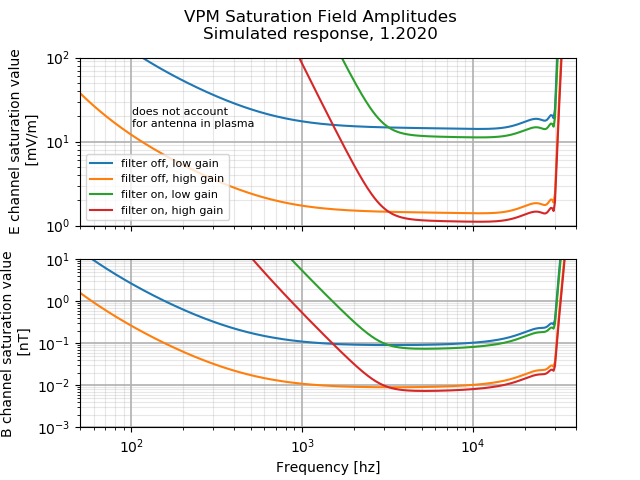

Text(0.5, 0.98, 'VPM Saturation Field Amplitudes\nSimulated response, 1.2020')

In [24]:
# Let's do the min/max range plots:

# Differential... 16 bit +- 1 volt
adc_max_val = 32727. 
adc_max_voltage = 1.0


E_high_gain = True
E_filter = False
B_high_gain = True
B_filter = False

E_full_response = E_ant_response + get_response(E_filter,E_high_gain)
B_full_response = B_ant_response + get_response(filt, gain) + 20*np.log10(10)


fig, ax = plt.subplots(2,1, sharex=True)
for filt, gain in [(False, False),(False, True), (True, False), (True,True)]:
    if filt:
        filt_str = "on"
    else:
        filt_str = "off"
    if gain:
        gain_str = "high"
    else:
        gain_str = "low"
    E_full_response = E_ant_response + get_response(filt, gain)
    B_full_response = B_ant_response + get_response(filt, gain) + 20*np.log10(10)
    
    E_saturation = 1000*adc_max_voltage/(pow(10,E_full_response/20))
    B_saturation = adc_max_voltage/(pow(10,B_full_response/20))

    ax[0].plot(f_vec, E_saturation, label=f'filter {filt_str}, {gain_str} gain')
    ax[1].plot(f_vec, B_saturation)
ax[1].set_xscale('log')
ax[1].set_xlim([50,40000])

ax[0].set_ylabel('E channel saturation value\n [mV/m]')
ax[1].set_ylabel('B channel saturation value\n [nT]')
ax[0].set_ylim([1,100])
ax[1].set_ylim([0.001,10])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].grid(which='major', linewidth=1.2)
ax[0].grid(which='minor', alpha=0.3)
ax[1].grid(which='major', linewidth=1.2)
ax[1].grid(which='minor', alpha=0.3)
ax[0].legend(fontsize=8)
ax[1].set_xlabel('Frequency [hz]')
ax[0].text(101, 15, "does not account\nfor antenna in plasma",fontsize=8)
fig.suptitle('VPM Saturation Field Amplitudes\nSimulated response, 1.2020')
# ax[0].set_ylabel(r'$\sqrt{Hz}$')
